# ANALYSIS OF DIFFERENT GLUTAMINE ROTAMERS  

In [112]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import mdtraj as md
import seaborn as sns
from scipy.stats import gaussian_kde
import pandas as pd
from Bio.SeqUtils import IUPACData

In [113]:
from __future__ import print_function
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import itertools
from itertools import product
import mdtraj.testing

#### Functions used for this analysis 

In [144]:
def get_residues(dirname):
    """
    Return the residue list from the topology
    """
    topname = os.path.join(dirname, 'prot.pdb')
    t = md.load(topname, stride=1)
    return list(t.top.residues)


def calc_helicity(dirname, temp=1,equil=0):
    """
    Calculate the helicity from a trajectory
    """
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    print (t)
    ss = md.compute_dssp(t)
    return ss =='H', ss =='C'


def helicity_hbond (dirname, temp=1, equil=0):
    new_t = trajectory_hbond(dirname,equil=0)
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_H_bond_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    ss = md.compute_dssp(t)
    return ss =='H', ss =='C'

    
def helicity_helix (dirname, temp=1, equil=0):
    new_traj = trajectory_helix (dirname,equil=0)
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f't{temp}_helix.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    ss = md.compute_dssp(t)
    return ss =='H', ss =='C'


def calc_H_bonds (dirname, temp=1, equil=0):
    """
    Calculate the H_bonds between Q1 and L1.
    In fact this just returns the distance not the H-bond.
    """
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    donors = t.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
    if donors.size==0: return np.array([9999.])
    #Selecting the oxigen of L1
    acceptor = t.topology.select('residue 7 and name O')
    pairs = list(product(donors, acceptor))
    #calculating the distances between these 2 atoms
    d = md.compute_distances(t, pairs)
    #We take the shortest distance
    d = d.min(1)
    d *= 10 #to angstroms
    return d


def trajectory_helix (dirname, temp=1, equil=0):
    """
    Calculate the new trajectory, which is the one only containing the frames where we have helices and NOT THE COIL
    """
    #upload the trajectory/topology
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    #calculate the helicity
    ss = md.compute_dssp(t,simplified=True)
    ss_helix = (ss =='H').astype(np.float)
    #Select the frames where resi6 to resi12 are helical
    index = np.all(ss_helix[:,8:13]>0,1)
    #Calculate the new trajectory
    t1_helix = t[index]
    t1_helix.save(os.path.join(dirname, f't{temp}_helix.xtc'))
    print (t1_helix)
    return t1_helix


def trajectory_coil (dirname, temp=1, equil=0):
    """
    Calculate the new trajectory, which is the one only containing the frames where we have helices and NOT THE COIL
    """
    #upload the trajectory/topology
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    #calculate the helicity
    ss = md.compute_dssp(t,simplified=True)
    ss_coil = (ss =='C').astype(np.float)
    #Select the frames where resi6 to resi12 are helical
    index = np.all(ss_coil[:,18:21]>0,1)
    #Calculate the new trajectory
    t1_coil = t[index]
    t1_coil.save(os.path.join(dirname, f't{temp}_coil.xtc'))
    print (t1_coil)
    return t1_coil


def trajectory_hbond (dirname, temp=1, equil=0):
    """
    Calculate the new trajectory, which is the one only containing the frames where we can see a sc-mc hydrogen
    bond between Q1-L1.
    """
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    index = (calc_H_bonds (dirname,equil=0)) < 2.3
    t1=t[index]
    t1.save(os.path.join(dirname,'prod1_H_bond_prot.xtc'))
    print (t1)
    return t1


def plot_helicity(helix, residues, blocks=5, equil=0, **kwargs):
    """
    Plot the helicity from an array of (N,M) of calculated helicities 
    """
    #Remove equilibration
    helix = helix[equil:]
    n_frames = helix.shape[0]
    step = n_frames//blocks
    values = [helix[i*step:(i+1)*step].mean(0) for i in range(blocks)]
    #df=pd.DataFrame(values, columns=[s+str(i) for i,s in enumerate('KKPGASLLLL'+12*'Q'+'KK')]).T
    #df=pd.DataFrame(values, columns=[s for s in 'KKPGASLLLL'+12*'Q'+'KK']).T
    df=pd.DataFrame(values).T
    #import statistics
    #helicity_Q1 = statistics.mean(df.iloc[10,0:5])
    #print (helicity_Q1)
    df =df.unstack().reset_index()
    df.columns=['repetion', 'residue', 'helicity']
    print (df)
    print (df.iloc[10,2])
    ax=sns.lineplot(x='residue', y='helicity', data=df, sort=False, **kwargs)
    #plt.xticks(np.arange(helix[name].shape[1]), 'KKPGASLLLL'+12*'Q'+'KK')
    #ax.set_xticks(np.arange(helix.shape[1]) )
    #ax.set_xticklabels('KKPGASLLLL'+12*'Q'+'KK')
    ax.grid(True)
    plt.legend()
    plt.ylim(None, 1.1)
    ticks=''.join([IUPACData.protein_letters_3to1[r.name.title()] for r in residues])
    plt.xticks(np.arange(helix.shape[1]), ticks)




### Helicity when the sc(i)-mc(i-4) H-bond occurs

In [123]:
helix = {}
coil = {}
residues = {}
#system_list = ('A4_Q12_a99SB-disp','L4_Q12_a99SB-disp','L4_Q8_a99SB-disp','Q1EH_a99SB-disp')
system_list = ('A4_Q12_DES-amber','L4_Q8_DES-amber','L4_Q12_DES-amber','Q1EH_DES-amber')
for system in system_list: 
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    #equil is the equilibration time, which is discarded
    helix[system], coil[system] = helicity_hbond(path, equil=0)
    #Print the length of the trajectory
    print('{:60s} -- {:5d}'.format(path, helix[system].shape[0]))
    residues[system] = get_residues(path)


<mdtraj.Trajectory with 112 frames, 377 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/A4_Q12_DES-amber          --   112
<mdtraj.Trajectory with 461 frames, 345 atoms, 20 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/L4_Q8_DES-amber           --   461
<mdtraj.Trajectory with 722 frames, 413 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/L4_Q12_DES-amber          --   722
<mdtraj.Trajectory with 242 frames, 412 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/Q1EH_DES-amber            --   242


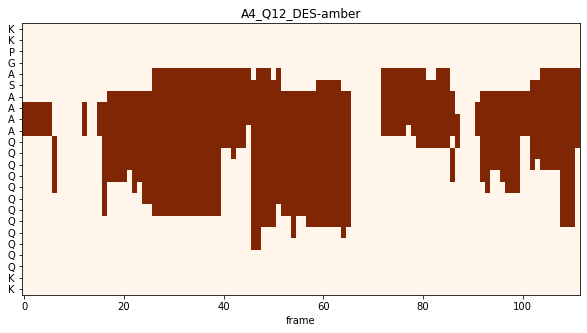

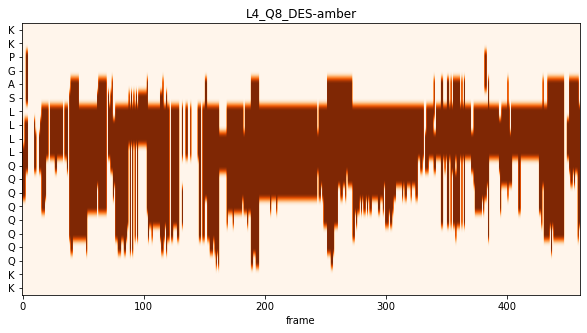

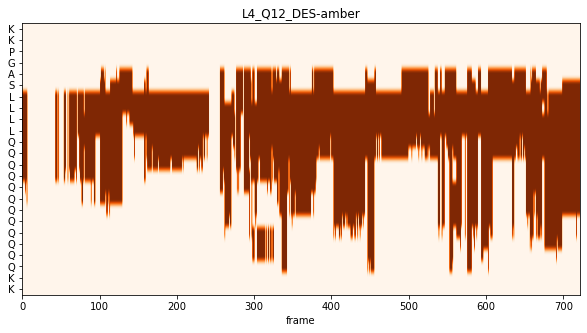

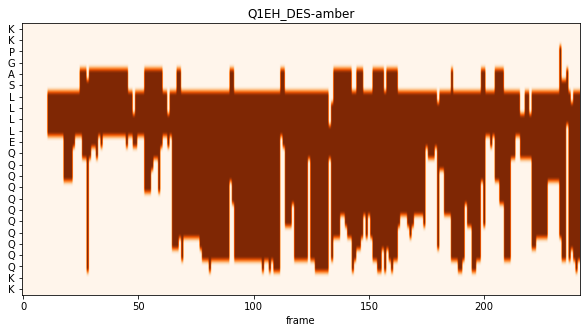

In [124]:
for name in helix:
    plt.figure(name, figsize=(10,5))
    plt.imshow(helix[name].T, aspect='auto',cmap='Oranges')
    plt.xlabel('frame')
    plt.ylabel('Residues')
    plt.title(name)
    ticks=''.join([IUPACData.protein_letters_3to1[r.name.title()] for r in residues[name]])
    plt.yticks(np.arange(helix[name].shape[1]), ticks)

           0         1         2         3         4
0   0.000000  0.000000  0.000000  0.000000  0.000000
1   0.000000  0.000000  0.000000  0.000000  0.000000
2   0.000000  0.000000  0.000000  0.000000  0.000000
3   0.000000  0.000000  0.000000  0.000000  0.000000
4   0.000000  0.818182  0.272727  0.545455  0.272727
5   0.000000  0.818182  0.590909  0.636364  0.363636
6   0.227273  1.000000  1.000000  0.681818  0.818182
7   0.636364  1.000000  1.000000  0.681818  0.863636
8   0.636364  1.000000  1.000000  0.727273  0.863636
9   0.636364  1.000000  0.954545  0.681818  0.863636
10  0.318182  1.000000  0.954545  0.363636  0.727273
11  0.318182  0.863636  0.909091  0.045455  0.727273
12  0.318182  0.818182  0.909091  0.045455  0.681818
13  0.272727  0.818182  0.909091  0.045455  0.363636
14  0.090909  0.772727  0.909091  0.000000  0.272727
15  0.045455  0.727273  0.909091  0.000000  0.090909
16  0.045455  0.636364  0.863636  0.000000  0.090909
17  0.000000  0.000000  0.681818  0.000000  0.

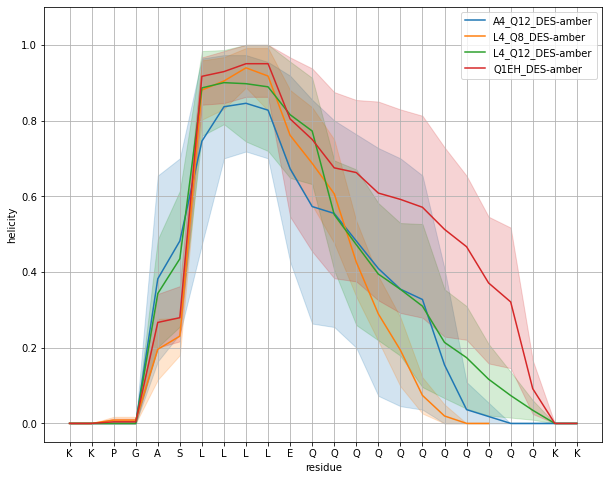

In [145]:
plt.figure(figsize=(10,8))
for name in helix:
    #uncomment for separate plots
    #plt.figure(figsize=(10,7))
    plot_helicity(helix[name], residues[name], label=name, equil=0)

### Helicity when residues from 6 to 12 are helical 

In [109]:
helix = {}
coil = {}
residues = {}
system_list = ('L4_Q12_a99SB-disp','L4_Q12_DES-amber','Q1EH_a99SB-disp','Q1EH_DES-amber')
for system in system_list: 
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    #equil is the equilibration time, which is discarded
    helix[system], coil[system] = helicity_helix(path, equil=0)
    #Print the length of the trajectory
    print('{:60s} -- {:5d}'.format(path, helix[system].shape[0]))
    residues[system] = get_residues(path)


<mdtraj.Trajectory with 8086 frames, 413 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/L4_Q12_a99SB-disp         --  8086
<mdtraj.Trajectory with 7022 frames, 413 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/L4_Q12_DES-amber          --  7022
<mdtraj.Trajectory with 8077 frames, 412 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/Q1EH_a99SB-disp           --  8077
<mdtraj.Trajectory with 7383 frames, 412 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/Q1EH_DES-amber            --  7383


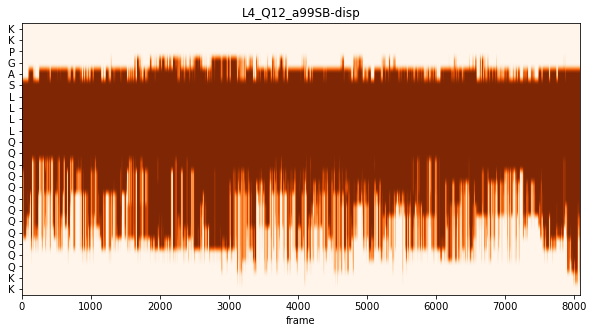

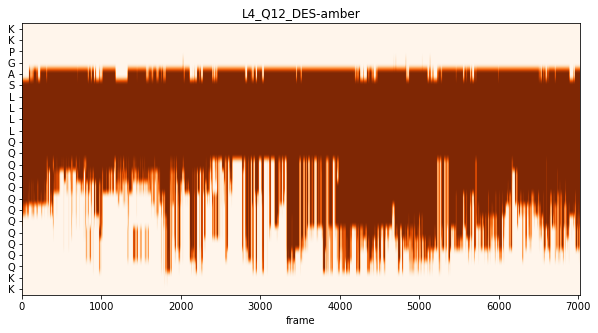

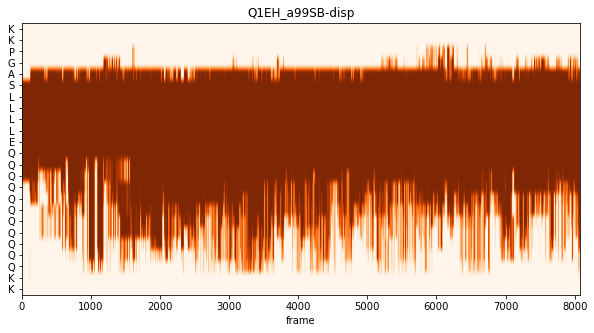

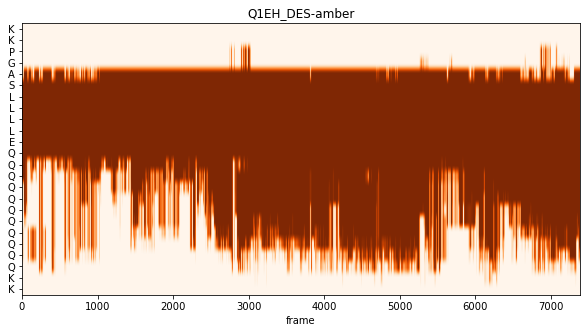

In [110]:
for name in helix:
    plt.figure(name, figsize=(10,5))
    plt.imshow(helix[name].T, aspect='auto',cmap='Oranges')
    plt.xlabel('frame')
    plt.title(name)
    ticks=''.join([IUPACData.protein_letters_3to1[r.name.title()] for r in residues[name]])
    plt.yticks(np.arange(helix[name].shape[1]), ticks)

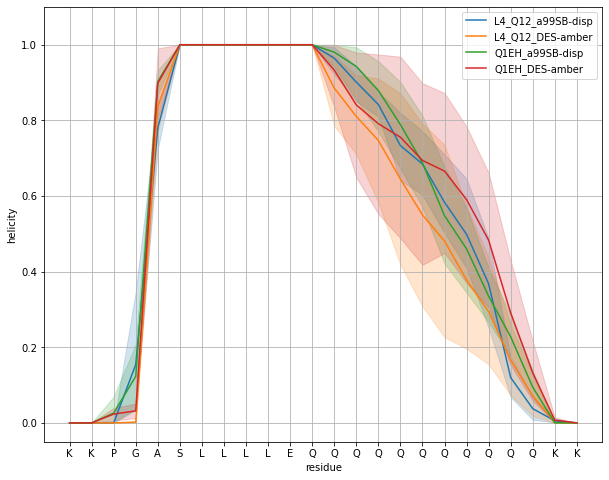

In [111]:
plt.figure(figsize=(10,8))
for name in helix:
    #uncomment for separate plots
    #plt.figure(figsize=(10,7))
    plot_helicity(helix[name], residues[name], label=name, equil=0)

### Q1 Dihedrals angles and Janin plot

In [64]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PDB, GRO, XTC
from MDAnalysis.analysis import dihedrals
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

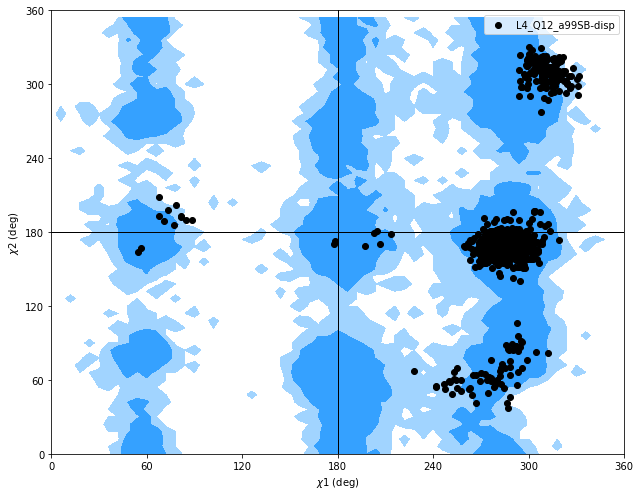

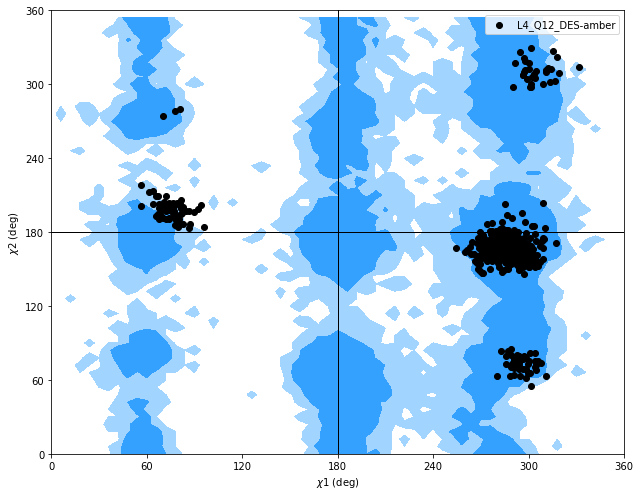

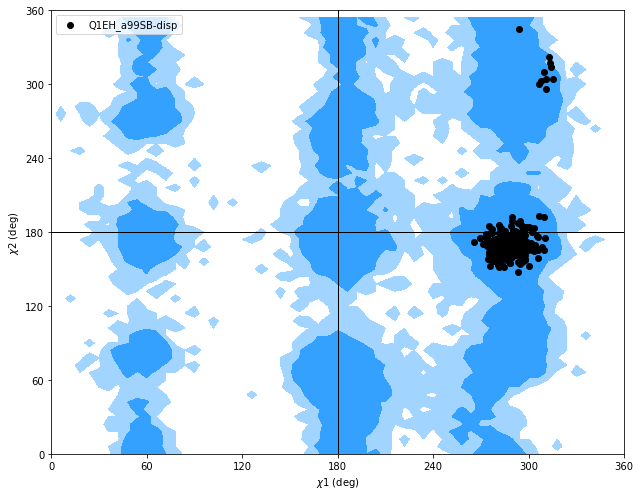

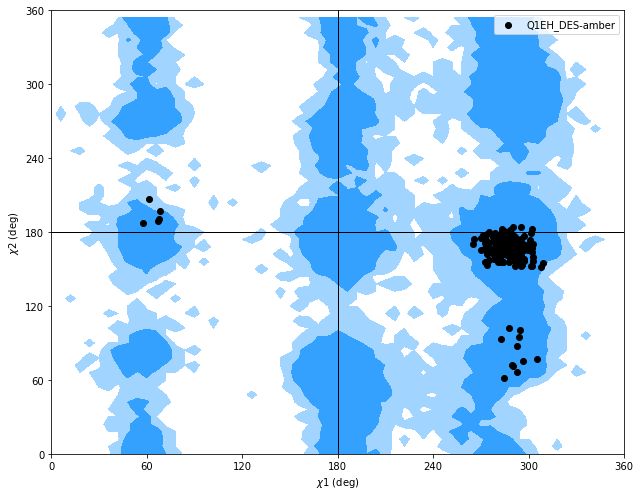

In [65]:
system_list2 = ('L4_Q12_a99SB-disp','L4_Q12_DES-amber','Q1EH_a99SB-disp','Q1EH_DES-amber')

for element in system_list2: 
    temp = 1
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/GOOD/{element}'
    topname = os.path.join(path, 'prot.pdb')
    trajname = os.path.join(path, f'prod{temp}_H_bond_prot.xtc')
    u = mda.Universe(topname, trajname)
    r = u.select_atoms("resid 11")
    J = dihedrals.Janin(r).run()
    
    fig, ax = plt.subplots(figsize=(9,7))
    J.plot(ax=ax, color='k', marker='o', ref=True, label=element)
    fig.tight_layout()
    plt.legend()
